Redoing TESS analysis with updated methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import lightkurve as lk
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Box1DKernel


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
search_result = lk.search_lightcurve('TIC 416538823')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,416538823,0.0
1,TESS Sector 15,2019,TESS-SPOC,1800,416538823,0.0
2,TESS Sector 15,2019,QLP,1800,416538823,0.0
3,TESS Sector 22,2020,SPOC,120,416538823,0.0
4,TESS Sector 22,2020,TESS-SPOC,1800,416538823,0.0
5,TESS Sector 22,2020,QLP,1800,416538823,0.0


In [4]:
lc = search_result[0].download(download_dir='data/') 

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

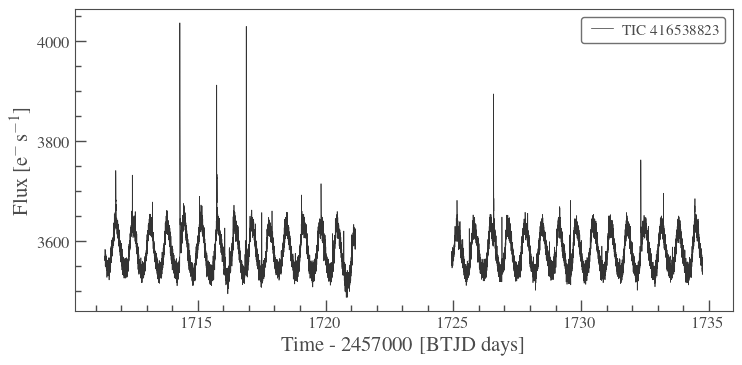

In [5]:
lc.plot()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

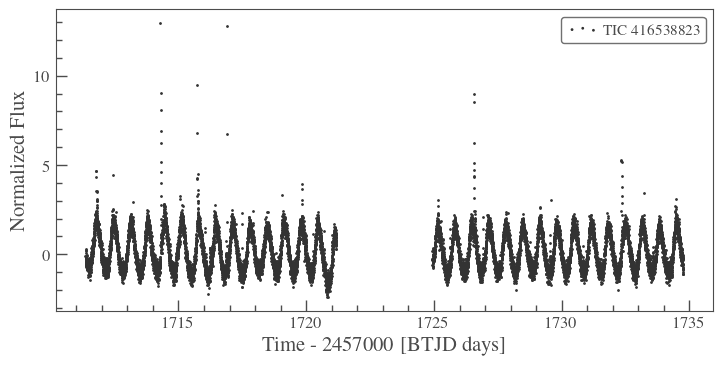

In [6]:
# lcn = lc.flatten(10001)
lcn=lc.normalize()
lcn.flux = lcn.flux.value -1
lcn.flux = lcn.flux*100
lcn.flux_err = lcn.flux_err.value*100

lcn.scatter()

0.6684953256775916 d


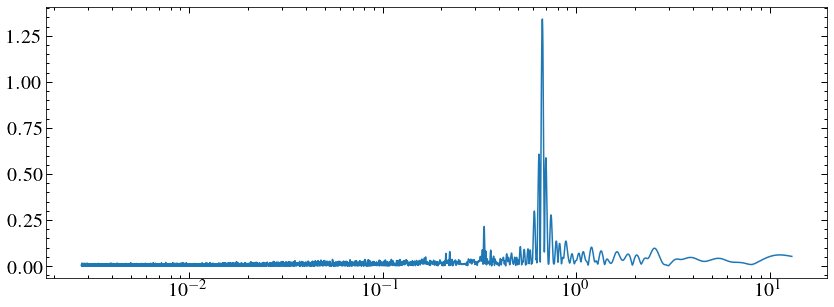

In [7]:
pg = lcn.to_periodogram(method='ls',oversample_factor=10, minimum_period=4*u.min, maximum_period = 13*u.d)
# pg = lcn.to_periodogram(method='bls')
plt.plot(pg.period, pg.power)
period = pg.period_at_max_power
print(pg.period_at_max_power)
plt.xscale('log')

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude         frequency             phase       
    ----------------- ------------------ -------------------
    -1.33812023553998 1.4891329233355157 0.10659821210251909
Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-1.33956724, frequency=1.46670508, phase=0.10851029)>

    [1]: <Sine1D(amplitude=0.22685333, frequency=3.00596715, phase=0.0526276)>
Parameters:
        amplitude_0        frequency_0           phase_0       ...    frequency_1          phase_1       
    ------------------- ------------------ ------------------- ... ----------------- --------------------
    -1.3395672350426928 1.4667050762454852 0.10851029295665017 ... 3.005967153344995 0.052627596738654005


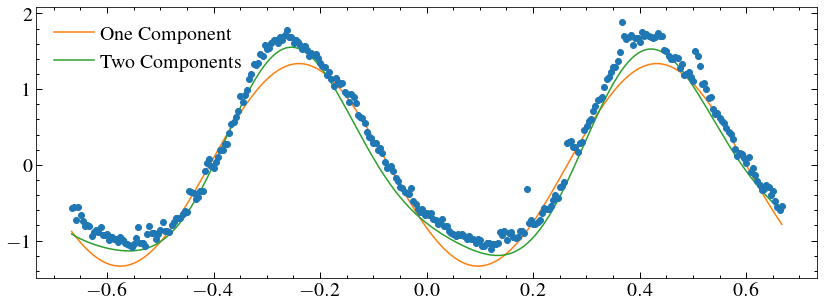

In [13]:
fitter = fitting.LevMarLSQFitter()

lcf = lcn.fold(period*2).bin(0.1*u.hr)
plt.errorbar(lcf.time.value, lcf.flux, yerr=lcf.flux_err, marker='o', ls='none')
# plt.show()


sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value)
sin_fit = fitter(sin_mod, lcf.time.value, lcf.flux.value, weights = 1/lcf.flux_err.value, maxiter=10000)
print(sin_fit)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# timefit = np.linspace(lc.time[0].value, lcf.time[-1].value, 2000)
plt.plot(lcf.time.value, sin_fit(lcf.time.value), label = 'One Component')

sin_mod =  models.Sine1D(amplitude=pg.max_power, frequency= pg.frequency_at_max_power.value) + models.Sine1D(amplitude=pg.max_power, frequency= (pg.frequency_at_max_power.value)*2)
sin_fit = fitter(sin_mod, lcf.time.value, lcf.flux.value, weights = 1/lcf.flux_err.value, maxiter=10000)
print(sin_fit)
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# timefit = np.linspace(lc.time[0].value, lcf.time[-1].value, 2000)
plt.plot(lcf.time.value, sin_fit(lcf.time.value), label = 'Two Components')
plt.legend()

Plots to send to TB

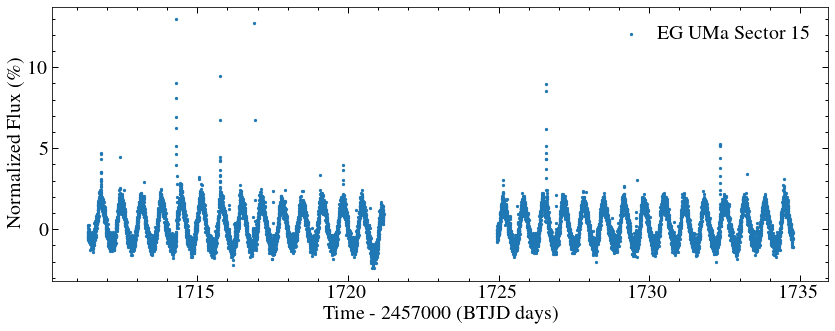

0.6684953256775916 d


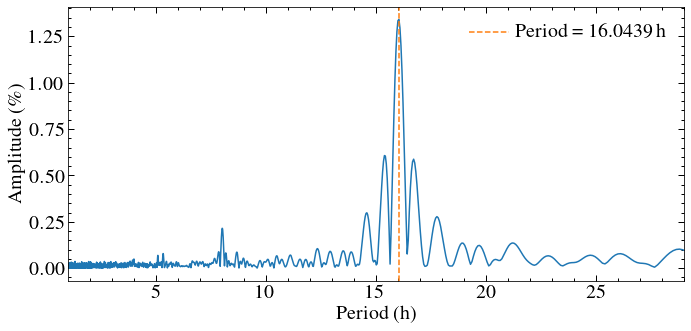

In [9]:
plt.figure(figsize=(12,5))
plt.scatter(lcn.time.value, lcn.flux, s=5, label = 'EG UMa Sector 15')
plt.xlabel('Time - 2457000 (BTJD days) ')
plt.ylabel('Normalized Flux (\%)')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('plots/eg_uma_tess_s15.pdf', dpi=150)
plt.show()
plt.figure(figsize=(10, 5))
period = pg.period_at_max_power
plt.plot(pg.period.to(u.h), pg.power)
plt.axvline(period.to(u.h).value, ls='--', c='C1', label = 'Period = {0:10.4f}\,h'.format(period.to(u.h).value))
# plt.xscale('log')
plt.xlim(1, 29)
plt.xlabel('Period (h)')
plt.ylabel('Amplitude (\%)')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('plots/eg_uma_s15_periodorgram.pdf')

print(period)

In [10]:
0.66757877*24

16.02189048

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-1.33956724, frequency=1.46670508, phase=0.10851029)>

    [1]: <Sine1D(amplitude=0.22685333, frequency=3.00596715, phase=0.0526276)>
Parameters:
        amplitude_0        frequency_0           phase_0       ...    frequency_1          phase_1       
    ------------------- ------------------ ------------------- ... ----------------- --------------------
    -1.3395672350426928 1.4667050762454852 0.10851029295665017 ... 3.005967153344995 0.052627596738654005


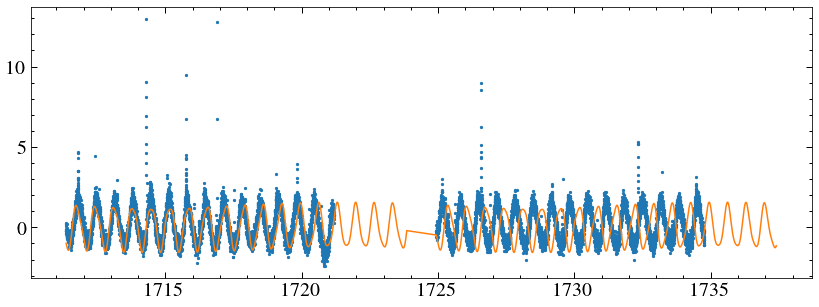

In [23]:
fitter = fitting.LevMarLSQFitter()

# lcf = lcn.fold(period*2).bin(0.1*u.hr)
# plt.errorbar(lcf.time.value, lcf.flux, yerr=lcf.flux_err, marker='o', ls='none')
# plt.show()
plt.scatter(lcn.time.value, lcn.flux, s=5, label = 'EG UMa Sector 15')

sin_mod2 =  models.Sine1D(amplitude=sin_mod[0].amplitude, frequency= sin_mod[0].frequency)+models.Sine1D(amplitude=sin_mod[1].amplitude, frequency= sin_mod[1].frequency)
sin_fit2 = fitter(sin_mod2, lcn.time.value, lcn.flux.value, weights = 1/lcn.flux_err.value, maxiter=10000)
print(sin_fit)
# sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
# timefit = np.linspace(lc.time[0].value, lcf.time[-1].value, 2000)
plt.plot(lcn.time.value, sin_fit(lcn.time.value), c='C1')